# Makemore 5: WaveNet

[Video](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)<br>
[Repository](https://github.com/karpathy/makemore)<br>
[Eureka Labs Discord](https://discord.com/invite/3zy8kqD9Cp)

## Table of Contents

- [Network Setup](#network-setup)
- [Addressing the noisy loss graph](#addressing-the-noisy-loss-graph)
- [Improving the Forward Pass](#improving-the-forward-pass)
- [More simplifications](#more-simplifications)
- [Going deeper](#going-deeper)
- [Dilated Causal Convolutional Layers](#dilated-causal-convolutional-layers)
- [BatchNorm Bug?!](#batchnorm-bug)
- [Going wider](#going-wider)
- [Development Process of Deep Neural Networks](#development-process-of-deep-neural-networks)
    - [Rough Roadmap](#rough-roadmap)
    - [Challenge for now](#challenge-for-now)

With the Makemore lectures, we've up until now built the processing- and training-structures for this particular approach:<br><br>
![](./img/bengioetal03.PNG)

This particular setup by [\[Bengio et al. 2003\]](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) receives three characters
and goes on to predict a fourth from a single hidden layer and a softmax output.

**But there's a problem with that**.

If we input more characters, the input layer's width increases, computation slows with an increased amount of parameters, and the hidden layer may become a bottleneck.<br>
Going down this route limits scalability and capability.<br><br>
To increase the model's capabilities more elegantly, we will have to input more characters; and crucially, we will have to deepen the model.<br>
We can address this by progressively combining the inputs across multiple deeper layers, rather than doing so all at once between the input and hidden layers.

![](./img/convolutions.png)

> **Too many individual inputs into a single layer are just not that scalable and will result in an increasingly murky representation by that layer.**<br>
> **We want to avoid that from now on.**

We replace the *wide-input-to-hidden-layer* bottleneck with multiple deeper layers, progressively fusing the input representations.<br>
This scaling approach was also described in the paper about [WaveNet](https://arxiv.org/abs/1609.03499), an audio-based language model.<br>Fundamentally, though, the structure still remains the same as with [\[Bengio et al. 2003\]](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), just with more layers.

For a start, we will copy over some code from [Makemore 3](../N004%20-%20Makemore%203%20-%20Activations,%20BatchNorm/N004%20-%20Makemore_3.ipynb):

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words
words = open('../names.txt', 'r').read().splitlines()
print('Word Count:', len(words))
print('Max Word Length:', max(len(w) for w in words))
print(words[:8])

Word Count: 32033
Max Word Length: 15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# Build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words))))  # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0                              # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()}       # Switch order of (char, counter) to (counter, char)

vocab_size = len(itos)

# Showing the two mappings, they really just are mirrors of one another
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [4]:
# Randomize the set of words (with reproducibility)
import random
random.seed(42)
random.shuffle(words)

We will first apply our usual `block_size` of $3$:

In [6]:
# Build the dataset
block_size = 3 # Context length: How many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
    
  print(X.shape, Y.shape)
  return X, Y

# These are the "markers" we will use to divide the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Dividing the dataset into train, dev and test splits
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Given a character triplet (`block_size`$=3$), the fourth character is the one we want to predict:

In [7]:
# Show the dataset's layout -> Three inputs, one expected output (given the three, expect the fourth)
# We have (as seen above) 182625 of these 'three, give fourth' sets of characters
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


## Network Setup

With [Makemore 3](../N004%20-%20Makemore%203%20-%20Activations,%20BatchNorm/N004%20-%20Makemore_3.ipynb) we started to develop the structure of Linear Layers and applied Batch Normalization to them.<br>
The code below is the same, but now compartmentalized.<br><br>
**This is on purpose.**<br><br>
Think of class instances as building blocks making up a network structure.<br>
This is easier to handle in the long run.

In [8]:
# Near copy/paste of the layers developed in Makemore 3
# -----------------------------------------------------

# Mimicks torch.nn.linear
class Linear:
  
  # fan_in: Number of input dimensions
  # fan_out: Number of output dimensions
  # bias: Whether to add a bias term or not
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # Kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  # Performs a forward pass if called (syntax: l = Linear(x))
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  # Returns a list of the parameters (syntax: l.parameters())
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


# Mimicks torch.nn.batchnorm1d
class BatchNorm1d:
  
  # dim represents the dimension along which the normalization is applied
  # PyTorch's BatchNorm is also performed along just one dimension
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps           # Small constant for numerical stability
    self.momentum = momentum # Running mean/variance momentum
    # Batchnorm1d behaves differently during training and production
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim) # Scaling
    self.beta = torch.zeros(dim) # Shifting
    # Buffers (trained with a running 'momentum update' outside backprop)
    self.running_mean = torch.zeros(dim) # Batchnorm mean
    self.running_var = torch.ones(dim)   # Batchnorm variance
  
  # Forward pass (syntax: bn = BatchNorm1d(x), where x is a batch of inputs)
  def __call__(self, x):
    # If we're in training mode, calculate the batch mean and variance (for active normalization)
    # Otherwise, use the running mean and variance (for passive normalization)
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean
      xvar  = x.var(0, keepdim=True)  # Batch variance
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var  = (1 - self.momentum) * self.running_var + self.momentum * xvar
    else:
      xmean = self.running_mean # Use pre-determined running mean/variance
      xvar  = self.running_var  # (pre-determined = calculated during training)
    
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta # Scale and shift (gamma and beta are learned)
    return self.out
  
  # Returns the list of this layer's parameters (syntax: bn.parameters())
  def parameters(self):
    return [self.gamma, self.beta]


# Mimicks torch.nn.tanh
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [10]:
torch.manual_seed(42); # Seed for reproducibility

With the above code, we can now build the actual network structure.

We'll do so just like before, with:
- an embedding layer with of size `(27, 10)`, 
- a hidden layer of size `(30, 200)`,
- a Batch Normalization layer across the hidden layer output's second dimension,
- a $\text{tanh}$ activation function,
- a linear layer of size `(200, 27)`

In [12]:
n_embd = 10    # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer of the MLP

# This sets up the actual network's design
C = torch.randn((vocab_size, n_embd))  # Random but unique n_embd-dimensional embedding vectors
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    Tanh(),
    Linear(n_hidden, vocab_size),
]

# Parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # Making last layer less confident (in beginning)

# Print the number of parameters in the model
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [14]:
# Same optimization as last time (written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    emb = C[Xb]                         # Embedding characters into vectors
    x = emb.view(emb.shape[0], -1)      # Concatenate the vectors, "stretch them out"
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the current (new) gradients
    
    # Update (mini-batch SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.2844
  10000/ 200000: 2.3177
  20000/ 200000: 2.4191
  30000/ 200000: 1.8858
  40000/ 200000: 1.9077
  50000/ 200000: 1.5355
  60000/ 200000: 1.6192
  70000/ 200000: 2.5743
  80000/ 200000: 2.0838
  90000/ 200000: 2.1183
 100000/ 200000: 2.2409
 110000/ 200000: 2.4485
 120000/ 200000: 2.1119
 130000/ 200000: 1.8765
 140000/ 200000: 2.1631
 150000/ 200000: 1.9839
 160000/ 200000: 2.3134
 170000/ 200000: 1.8970
 180000/ 200000: 1.7244
 190000/ 200000: 1.8793


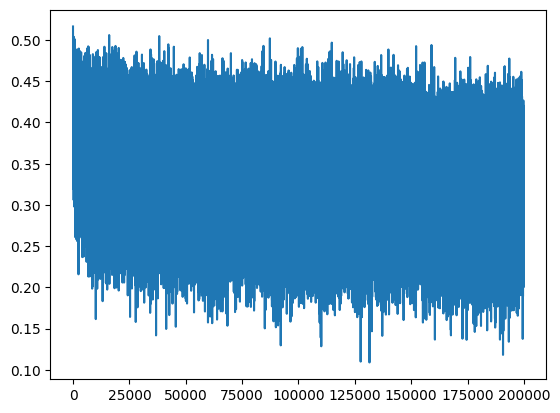

In [16]:
plt.plot(lossi);

Let's also determine the training and validation losses:

In [17]:
# Put layers into eval mode (needed for batchnorm ESPECIALLY)
for layer in layers:
    layer.training = False

In [ ]:
# See Makemore #2.
# We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side for this function)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]   # That's a switch!
    
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0587270259857178
val 2.1071507930755615


In [14]:
# Sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass though the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1)   # Concatenate the vectors, "streching them out"
      for layer in layers:
            x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    # Decode and print the generated words (Inferences)
    print(''.join(itos[i] for i in out))

damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


Up until now we basically just refactored the [Makemore 3](../N004%20-%20Makemore%203%20-%20Activations,%20BatchNorm/N004%20-%20Makemore_3.ipynb) approach.<br>
**It's still working exactly the same as before.**

If you take a look at the loss graph, it really looks *crazy*, just too *noisy*.<br>
**The main cause for this is the batch size.**

$32$ is too small. Per batch, we only have $32$ predictions.<br>
This is not enough to get a good/stable average loss value.<br>
Even worse, small batch sizes can make for loss-wise very 'lucky' or 'unlucky' batches, which can skew the loss graph even more.

**Let's fix this horrible loss graph.**

## Addressing the noisy loss graph

`lossi` is our accumulated list of `float` values, representing the loss values per each batch.<br>
To make the graph more readable, we can go and average the loss values over a certain number of batches.<br>
In this context, recall that we can 'malform' any $m$-dimensional array into an $n$-dimensional array.<br><br>
*This will be helpful.*

In [20]:
print(torch.arange(10))             # An array with numbers 0-9 -> (10,)
print(torch.arange(10).view(2, 5))  # Same array, but transformed -> (2,5)
print(torch.arange(10).view(5, 2))  # Same array, but transformed differently -> (5,2)
print(torch.arange(10).view(2, -1)) # -1 as joker, infers one dim automatically, given input dimensions -> (2,5)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])


In [22]:
print(len(lossi))

200000


We can mend `lossi` more easily if we turn it into a tensor.<br><br>
`lossi` has a length of $200,000$.<br>
We structure that into a matrix of shape `(200, 1000)`.<br><br>
For each row (carrying $1,000$ values), we calculate the average.<br>
With all these individual losses ($=200,000$) in total, we are now down to $200$ averaged losses.<br><br>
*This will be more readable.*

torch.Size([200, 1000])
torch.Size([200])


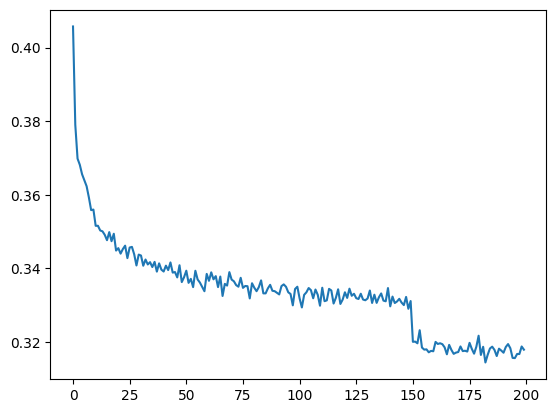

In [24]:
print(torch.tensor(lossi).view(-1, 1000).shape)         # Each row has 1000 consecutive losses
print(torch.tensor(lossi).view(-1, 1000).mean(1).shape) # Row-wise mean -> 200 means for 200 rows
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));   # Mean on every Row -> 200 means as array

This is a very simple approach to make the loss graph more readable. Elegant nonetheless.<br>
For example, **we can now clearly see where the learning rate was decreased, and that this indeed resulted in a finer approach of the "perfect" local minimum** i.e. less error overall.

## Improving the Forward Pass

The next thing we want to improve is the forward pass itself. <br>
**It's too bloated, too many lines of code.**<br><br>
Also the embedding table `C` is special-cased outside of the 'regular' layers.<br>
The `emb.view` also happens outside of the layers as an additional step.<br>
That is costly, because it's not parallelized.

**In other words:** There is this part in the forward pass code that is unnecessary:

```python
emb = C[Xb]
```

It is a lookup into the embedding table using the input character's integer representations as indices.<br>
We should incorporate this extra operation differently.<br>

The exact same goes for the vector flattening right after that:

```python
# Concatenate vectors
# emb.shape[0] is batch size, 
# -1 for automatic inference of block_size * n_embd
x = emb.view(emb.shape[0], -1)
```

We did organize some layers within the `layers` list already (Linear, BatchNorm1d, Linear).<br>
We could just treat those two operations as layers too and add them to that list.<br>
One will be the `Embedding` layer, the other one will be called `Flatten`.

Let's begin with the Embedding Layer.<br>
There is a functional equivalent in PyTorch, called `torch.nn.embedding`.<br><br>**The layer looks like this:**

In [33]:
# Does the indexing operation
# Mimicks torch.nn.embedding
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    # What was previously C (lookup table) is now the weight in this layer
    self.weight = torch.randn((num_embeddings, embedding_dim)) # Behaves just like C did

  # This is the forward pass (syntax: embedding(IX))   
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  # Returns list of all layer parameters (syntax: embedding.parameters())
  def parameters(self):
    return [self.weight]

In [34]:
# Does the vector flattening
class Flatten:
  # This is the forward pass (syntax: flatten(x))
  # x is a tensor of shape (N, block_size, n_embd), where N is the batch size, n_embd is the embedding dimension
  def __call__(self, x):
    # Concatenate the vectors, 
    # x.shape[0] is the batch size, 
    # -1 means "infer the rest" (in this case, block_size * n_embd)
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  # Returns list of all layer parameters (none in this case, syntax: flatten.parameters())
  def parameters(self):
    return []

This approach greatly improves readability and streamlines the layer processing, as we can now add these layers to the old `layers` list and plainly iterate over them as well.<br> *Same function, better understanding.*

In [36]:
torch.manual_seed(42);

In [37]:
n_embd   = 10  # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer of the MLP

# This sets up the actual network's design
layers = [
    Embedding(vocab_size, n_embd), # NEW: previously C = torch.randn((vocab_size, n_embd))
    Flatten(),                     # NEW: previously x = emb.view(emb.shape[0], -1)
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# Parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # Making last layer less confident

# OLD: parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


Not only the design, but also the interaction through forward pass and backward pass get simplified through our changes:

In [38]:
# Same optimization as last time (written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    x = Xb # batch input later gets embedded into vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the gradients
    
    # Update (mini-batch SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    break # We see if this works first

      0/ 200000: 3.2966


## More simplifications

**Let's now simplify our code further.**<br>
We store the layers in a list called `layers`.<br>
That's not be the most effective way to store them.<br>
Let's instead build something like a `container`.

Just like in `torch.nn`, this should be an organizer for our layers.<br>
The particular PyTorch idea that we'll copy is the `Sequential` container.<br>
It is able to, on its own, pass input though all the layers that it contains.<br>**Just what we need!**

Let's build this `Sequential` container:

In [39]:
# Mimicks torch.nn.Sequential
class Sequential:
  
  def __init__(self, layers):
    # Psst, this is basically the same list structure as before
    self.layers = layers
  
  # Simply pass input x through every layer in self.layers
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  # Get parameters of all layers, stretch them out into one list
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

Once again, this moving of processes to classes has positive implications for our network design and interactivity:

In [41]:
torch.manual_seed(42);

In [42]:
n_embd = 10    # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer of the MLP

# This sets up the actual network's design
model = Sequential([
    Embedding(vocab_size, n_embd), # previously C = torch.randn((vocab_size, n_embd))
    Flatten(),                     # previously x = emb.view(emb.shape[0], -1)
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # Making last layer less confident

# Parameters looked like this before: [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [43]:
# Same optimization as last time (just written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    logits = model(Xb) # our new Sequential container in action
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the current (new) gradients
    
    # Update (SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    #break # We see if this works first

      0/ 200000: 3.4915
  10000/ 200000: 2.2179
  20000/ 200000: 2.3681
  30000/ 200000: 2.1342
  40000/ 200000: 2.4067
  50000/ 200000: 2.2406
  60000/ 200000: 1.9608
  70000/ 200000: 1.9236
  80000/ 200000: 2.6587
  90000/ 200000: 2.0502
 100000/ 200000: 2.2596
 110000/ 200000: 1.6270
 120000/ 200000: 2.1705
 130000/ 200000: 2.2806
 140000/ 200000: 2.1980
 150000/ 200000: 1.8434
 160000/ 200000: 1.8250
 170000/ 200000: 2.3077
 180000/ 200000: 2.0817
 190000/ 200000: 2.1585


These simplifications carry their positive effect on readability through all of the pipeline:

torch.Size([200000])
torch.Size([200, 1000])
torch.Size([200])


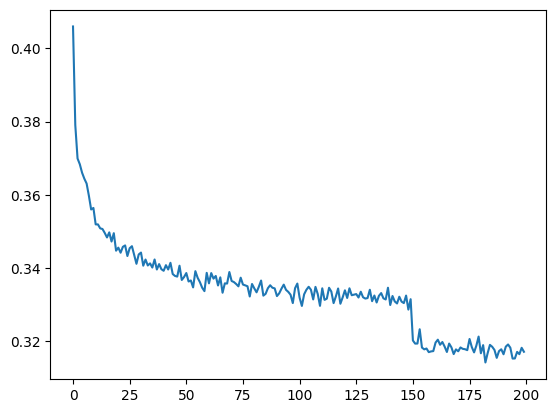

In [46]:
print(torch.tensor(lossi).shape)                        # (200000,)
print(torch.tensor(lossi).view(-1, 1000).shape)         # Make each row carry 1000 consecutive elements
print(torch.tensor(lossi).view(-1, 1000).mean(1).shape) # Row-wise (1) mean --> 200 rows/means
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));   # Mean on every Row -> 200 means

Let's also determine the training and validation losses:

In [47]:
# Put layers into eval mode (needed for batchnorm especially)
# (Accessing Sequential's layers directly like this is bad, we'll fix this later)
for layer in model.layers:
    layer.training = False

In [49]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side for this function)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]   # That's a switch!
    
    logits = model(x) # This got simplified
    
    loss = F.cross_entropy(logits, y)
    print(f'{split}\t{loss.item()}')

split_loss('train')
split_loss('val')

train	2.058220863342285
val	2.1056692600250244


In [50]:
# Sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass though the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    # Decode and print the generated words (Inferences)
    print(''.join(itos[i] for i in out))

ivon.
fanili.
thoommestenell.
mattevyn.
alana.
joleshaun.
siah.
prus.
carleen.
jah.
jorrena.
joriah.
jas.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.
esteffead.


We see that the losses on training and validation set are very similar to one another.<br>
**This hints at the model being able to generalize pretty well.**

**It does not overfit.** *That's good.*

This is a good basis for trying to increase the model size<br>
to deepen the understanding and further reduce the loss we have.

## Going deeper

**Ok, going back to the beginning.**<br><br>
Right now, we use a (more elegantly implemented) architecture to take in three letters and predict the fourth.<br>
The problem is that while we are able to in theory "just add more layers", in the beginning we effectively crush all the input characters into one layer.<br>
This is the architecture's core problem/bottleneck.<br><br>
The [WaveNet](https://arxiv.org/abs/1609.03499) approach addresses this:

![](./img/convolutions_1.PNG)

The different characters are fed in, and not just crushed into a single layer at once.<br>
This processes of crushing now happens much less harshly across several layers.<br>
**This lowers the risk of information loss**.

In the first layer, we "fuse" two characters.<br>
Then, we "fuse" the fusions of those two characters (now considering $4$ characters in total) and so on.<br>
A tree structure emerges, which we can scale in depth (therefore we can scale the context size) to our liking.

> This exact concept of stacking up layers and "tree-branch-style" merging inputs is called<br>
> **"dilated causal convolutional layers".**

**In short:**<br>
We're actually going to make the network deeper, but mostly regarding the input process.<br>
This will already add more information for us to learn from,<br>
as we can now take characters into account in a more "contextual" way.

First, let's increase the `block_size` from $3$ to $8$:

In [51]:
# Build the dataset
block_size = 8 # Context length: How many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
    
  print(X.shape, Y.shape)
  return X, Y

# These are the "markers" we will use to divide the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Dividing the dataset into train, dev and test splits
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [52]:
# Show the dataset's layout -> Eight inputs, one associated/expected output
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


The model architecture remains for now. The number of parameters has increased by $10,000$.<br>
This is due to the larger context size.

**The question for now is:**<br>
Does plainly increasing the context size yield a lower loss, all while still crushing everything into the first layer?

Let's try that:

In [53]:
n_embd = 10    # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer of the MLP

# Setting up the network's design
model = Sequential([
    Embedding(vocab_size, n_embd), # previously C = torch.randn((vocab_size, n_embd))
    Flatten(), # previously C.view(-1, n_embd * block_size)
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # Making last layer less confident

# before: [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [54]:
# Same optimization as last time (written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the current (new) gradients
    
    # Update (SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    #break # We see if this works first

      0/ 200000: 3.6036
  10000/ 200000: 2.1418
  20000/ 200000: 2.2006
  30000/ 200000: 2.4524
  40000/ 200000: 2.2123
  50000/ 200000: 1.8461
  60000/ 200000: 2.5121
  70000/ 200000: 2.1705
  80000/ 200000: 2.3022
  90000/ 200000: 2.2967
 100000/ 200000: 1.9490
 110000/ 200000: 2.0411
 120000/ 200000: 2.8504
 130000/ 200000: 1.5823
 140000/ 200000: 2.0511
 150000/ 200000: 2.0658
 160000/ 200000: 2.0859
 170000/ 200000: 1.7717
 180000/ 200000: 1.4267
 190000/ 200000: 2.0282


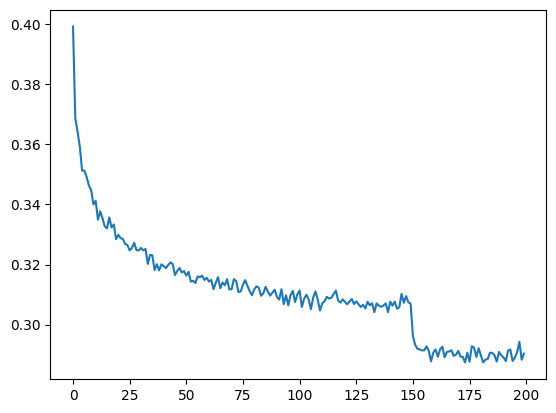

In [55]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)); # Mean on every Row -> 200 means

In [56]:
# Put layers into evaluation mode
for layer in model.layers:
    layer.training = False

In [58]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side for this function)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split] # That's a switch!!
    
    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(f'{split}\t{loss.item()}')

split_loss('train')
split_loss('val')

train	1.9186382293701172
val	2.0330464839935303


We actually see a **good improvement** concerning the loss here.<br>
And this is only due to making the batch size larger.<br>
*Nothing else, no structural changes yet.*

**Performance log:**
|                                         |train|val  |
| --------------------------------------- | --- | --- |
| original (3 characters, 12K params)     |2.058|2.105|
| context: 3 $\rightarrow$ 8 (22K params) |1.918|2.033|

In [59]:
# Sample from the 22K model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass though the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    # Decode and print the generated words (Inferences)
    print(''.join(itos[i] for i in out))

mahriah.
catheoj.
demanui.
briuja.
alim.
devon.
alunya.
duriyan.
amer.
catriana.
aryshail.
arpod.
nalynn.
elynn.
ozep.
lavade.
rudiel.
beitum.
micbelly.
karlene.


*Those names start to look better.*<br>
But let's now also make the model more scalable with the above discussed *'dilated causal convolutional layers'* approach.

## Dilated Causal Convolutional Layers

Let's build up some intuition on how this multilayer-input construct could be built.<br>
Below we can see the shape of the tensors throughout the network's layers.

**This is just for visualization:**

In [60]:
# Let's look at what a batch of just 4 examples does
ix = torch.randint(0, Xtr.shape[0], (4,))

# Take these 4 random rows from the training set
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb) # Run them through the model
print(Xb.shape)    # Total input set dimensions, 4x8; 4 is batch size, 8 is block size
print(Xb)          # Let's see the actual input batch

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  8],
        [ 0,  0,  0,  0,  5, 12, 12, 19],
        [ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0, 13,  1,  5,  2, 18]])


In [61]:
# Each character is represented by a 10-dimensional vector that we want to learn (we chose that)
print(model.layers[0].out.shape) # 4x8x10 -> 4 is batch size, 8 is block size, 10 is embedding size

torch.Size([4, 8, 10])


In [62]:
# Output of the Flatten Layer (compresses 8 and 10 together into one big concatenation per input)
print(model.layers[1].out.shape) # 4x80 -> 4 is batch size, 80 is inferred from 8x10

torch.Size([4, 80])


In [63]:
# Output of the Linear Layer (200 expected outputs created per input)
print(model.layers[2].out.shape) # 4x200 -> 4 is batch size, 200 is number of neurons in the hidden layer

# Digression/Refresher: How come [4, 80] turns into [4, 200]? See below for explanation
print((torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)
# We obtain 4 (batch size) activation sets of 200 activations each, just as planned
# The + torch.randn(200) is the bias

torch.Size([4, 200])
torch.Size([4, 200])


Interestingly, this last step can work no matter what dimensionality the input has.<br>
It always 'attaches' to the last dimension, ignoring $n \geq 0$ prior listed matrix dimensions:

In [66]:
# Just a sidenote, nothing structural
print((torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)

torch.Size([4, 5, 6, 200])


We can use this property to our advantage.<br><br>
We have `block_size=8` many characters:<br>
`1 2 3 4 5 6 7 8`

We embed each character into a $10$-dimensional vector. (Just as we always did.)

We now want to apply step-wise grouping over the embedded (now $10$-dimensional) characters:<br>
`(1 2) (3 4) (5 6) (7 8)`

We also want to do this in a way as to process the above emerging $4$ subgroups efficiently, in parallel.

Let's modify our previously applied matrix multiplication to be able to account for that.<br>
We only want $2$ characters to be fused in our first layer.<br>
These are the $4$ times (batch size) $4$ groups of $2$ characters,<br>
`(1 2) (3 4) (5 6) (7 8)`, where each character itself is $10$ dimensional<br>
(per group: $2$ characters $\times 10$ embeddings $= 20$):

In [69]:
# n_embd = 10    # Character embedding dimensionality
# We want this behavior for our new linear layer, it's just a draft for now:
print((torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape)

torch.Size([4, 4, 200])


The `Flatten` layer should therefore be adapted<br>
to not output $[4, 80]$, but $[4, 4, 20]$ (again $4 \times 4$ groups of $2$ characters, each of $10$ dimensions)<br>
so that it correctly feeds into the new linear layer which already accounts for the grouped input approach now.

We currently have an input of dim $(4, 8, 10)$ (`batch_size`, `block_size`, `embedding_size`).<br>
**Goal:** Get this to be $(4, 4, 20)$ with $20$ being $2$ consecutive $10$-dim vectors concatenated

In [71]:
e = torch.randn(4, 8, 10) # Mocked input to the flatten layer
# Currently, Flatten() creates just this reshaped version:
print(e.view(4, -1).shape)

torch.Size([4, 80])


To solve the re-arrangement task, we can utilize a concept from the python list API to reshape exactly how we want it right now.<br>
This is the concept we want to use:

In [81]:
print(list(range(10))[::2])
print(list(range(10))[1::2])

[0, 2, 4, 6, 8]
[1, 3, 5, 7, 9]


From every input in the batch (batch size $4$), we now pick only every second $10$-dimensional character embedding vector.<br>
Given `e` of shape $(4, 8, 10)$, we therefore have to plug out a shape $(4, 4, 10)$:

In [82]:
print(e[:, ::2, :].shape)  # Even character representations (zeroth, second etc.)
print(e[:, 1::2, :].shape) # Odd character representations (first, third etc.)

torch.Size([4, 4, 10])
torch.Size([4, 4, 10])


If we now concatenate these two tensors along their third dimension (zero-indexed in Python, so there is a $2$ in the code),<br>
we re-combine every even character embedding with just its following odd character embedding.

In [83]:
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
print(explicit.shape)

torch.Size([4, 4, 20])


*A remarkable move.*<br><br>
We have a $[4, 8, 10]$ input. We splice this one tensor into two, both of size $[4, 4, 10]$.<br>
The first tensor contains all the even number embeddings, and the second tensor contains all the odd number embeddings of the groups of embeddings.<br>
We then concatenate the tensors on their third dimension.<br>
We thus always paste the $10$-dimensional embedding of a second character to the back of the embedding of a first character.

In fact, we just did that operation very explicitly.<br>
PyTorch's `.view()` has our back in this case, we don't need to be as verbose.<br>
But its always good to see how this is done.

The simplified code utilizing `.view()` for the same task:

In [84]:
print((e.view(4, 4, 20) == explicit).all())

tensor(True)


**This can be generalized.**<br><br>
If a flattening layer was to receive a tensor of shape $[B, T, C]$ (`batch_size`, `characters`, `embedding_channels`),<br>
and it received an $n$ to group the characters into $n$ groups,<br>
we can generalize the reshaping to $[B, T//n, C \times n]$ (`batch_size`, `characters` divided by $n$, `embedding_channels` times $n$).

Let's now propagate our findings to the model architecture and specifically to the implementation of `Flatten`.<br>
These classes remain untouched:

In [85]:
# Mimicks torch.nn.linear

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # Kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  # Performs a forward pass if called (syntax: l = Linear(x))
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------

# Mimicks torch.nn.batchnorm1d
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    # Batchnorm1d behaves differently during training and production
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trained with a running 'momentum update' outside backprop)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # Calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batchnorm mean
      xvar = x.var(0, keepdim=True) # Batchnorm variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------

# Mimicks torch.nn.tanh
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

# Mimicks torch.nn.embedding, does the indexing operation
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    # What was previously C (lookup table) is now the weight in this layer
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------

# Mimicks torch.nn.Sequential
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers      # This is basically the same list structure as before
  
  def __call__(self, x):      # Simply pass input x through every layer in self.layers
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers, stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

This one is new:

In [86]:
# NOT ANYMORE mimicking torch.nn.flatten
class FlattenConsecutive:
    
  def __init__(self, n):  # n is the number of consecutive elements to be concatenated
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape # 4, 8, 10 in example before
    x = x.view(B, T//self.n, C*self.n) # Flattening in groups, now 4, 4, 20 for n=2 characters
    if x.shape[1] == 1:
        x = x.squeeze(1) # Takes out the dimension 1, as it only has value 1 (irrelevant)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

In [88]:
torch.manual_seed(42); # For reproducibility

Let's now set up the thinned and deepened model architecture:

In [89]:
n_embd   = 10 # Dimensionality of the character embedding vectors
n_hidden = 68 # Number of neurons in the hidden layer of the MLP

# This sets up the actual network's design
model = Sequential([
    Embedding(vocab_size, n_embd),   # Previously C = torch.randn((vocab_size, n_embd))
    # The new layer at work now (block_size was 8 before)
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # Making last layer less confident

# before: [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [90]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Looking again at a random batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0, 13,  9, 12,  9,  1],
        [ 0,  0,  0,  1, 22,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0, 11,  8, 25, 14]])


In [92]:
# This is neat, it shows the shape of the output of each layer
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


We now have built what was set out in the paper:<br>

![](./img/convolutions_1.PNG)

**But not quite.** The total receptive field size of the paper's model is $16$. We have $8$.<br>
Basically, it's one squashing layer less.<br>
With the above architecture, we actually shrunk `n_hidden` from $200$ down to $68$.<br>
We now have a very different NN architecture, but roughly the same amount of parameters in total.<br>
We can now see whether our architectural changes optimized the use of the parameter amount or not.

**Let's train!**

In [93]:
# Same optimization as last time (written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the current (new) gradients
    
    # Update (SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    #break # We see if this works first

      0/ 200000: 3.5555
  10000/ 200000: 2.2055
  20000/ 200000: 2.4019
  30000/ 200000: 2.1561
  40000/ 200000: 2.1377
  50000/ 200000: 2.2740
  60000/ 200000: 2.0626
  70000/ 200000: 1.8016
  80000/ 200000: 2.0158
  90000/ 200000: 2.0814
 100000/ 200000: 1.6752
 110000/ 200000: 2.3915
 120000/ 200000: 2.3702
 130000/ 200000: 2.1049
 140000/ 200000: 2.2882
 150000/ 200000: 1.7862
 160000/ 200000: 2.0824
 170000/ 200000: 2.2584
 180000/ 200000: 2.0024
 190000/ 200000: 1.7854


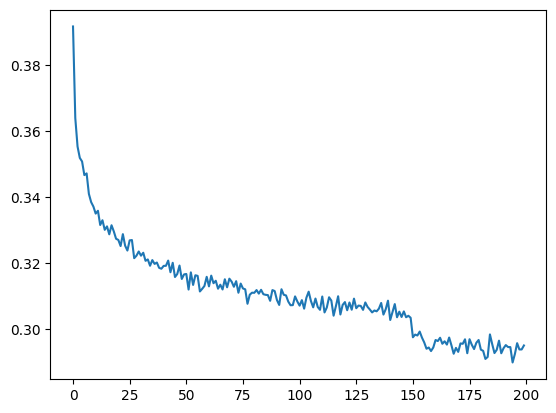

In [94]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [95]:
# Put layers into evaluation mode (needed esp. for batchnorm)
for layer in model.layers:
    layer.training = False

In [96]:
# Evaluate the loss
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side for this function)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9428514242172241
val 2.0290133953094482


**Performance log:**

|                                              |train|val  |
| -------------------------------------------- | --- | --- |
| original (3 characters, 12K params)          |2.058|2.105|
| context: 3 $\rightarrow$ 8 (22K params)      |1.918|2.033|
| flat $\rightarrow$ hierarchical (22K params) |1.942|2.029|

In [97]:
# Sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all zeros (representing the special '.' token)
    while True:
      # Forward pass though the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    # Decode and print the generated words (Inferences)
    print(''.join(itos[i] for i in out))

zhlene.
jafar.
aleala.
zyanna.
sarman.
gidella.
lucove.
wilvi.
jerediah.
yanua.
keerthaus.
bryrio.
loursten.
aahli.
janaisha.
leynn.
zahmia.
ellam.
breck.
kendrix.


## BatchNorm Bug?!

We still have this curious bug with our `BatchNorm1d` layer.<br>
It runs, but **does it even do the right thing?**<br><br>
Let's see:

In [98]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (1, 8, 10)
FlattenConsecutive : (1, 4, 20)
Linear : (1, 4, 68)
BatchNorm1d : (1, 4, 68)
Tanh : (1, 4, 68)
FlattenConsecutive : (1, 2, 136)
Linear : (1, 2, 68)
BatchNorm1d : (1, 2, 68)
Tanh : (1, 2, 68)
FlattenConsecutive : (1, 136)
Linear : (1, 68)
BatchNorm1d : (1, 68)
Tanh : (1, 68)
Linear : (1, 27)


The first `BatchNorm1d` receives a $[32, 4, 68]$ input.<br>
This is three-dimensional. **But our current `BatchNorm1d` only accounts for 2D inputs.**

**What? How did we get an output then anyway?**

Everything broadcasts properly across the model, but the `BatchNorm1d` layer just does ... something. *Anything.*<br>
We still have a learning effect that somewhat compensates this rogue behavior, though.<br>
This is what keeps `BatchNorm1d` seem to run smoothly. **But it doesn't.**

**Let's think our way through BatchNorm1d:**

In [117]:
# Our faulty BatchNorm1d works like this:
e = torch.randn(32, 4, 68)      # 32 examples, 4 characters, 68 embeddings
emean = e.mean(0, keepdim=True) # (1, 4, 68); mean ONLY over the very first dimension
evar = e.var(0, keepdim=True)   # (1, 4, 68); variance ONLY over the very first dimension
ehat = (e-emean) / torch.sqrt(evar + 1e-5) # (32, 4, 68); normalize over the first dimension
print(ehat.shape)

torch.Size([32, 4, 68])


In [118]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

The means are only taken over $32$ inputs of the first dimension. Each input is now itself a vector $[4, 68]$. *That's the point.*<br>
The `running_mean` this way becomes $[1, 4, 68]$ instead of the expected $68$.<br>
This tells us that the current implementation 'batch-normalizes' in parallel over $4$ times $68$ channels,<br>
instead of only $68$ channels total.<br>

> We normalize over groups of character embeddings, instead of over the character embeddings themselves.<br>
> Small groups, so admittedly it's not too bad, but it still distorts the normalization process.

So, we actually want to average over the $32\times 4$ embeddings, each with $68$ channels.<br>

> We want the $68$ channel wide average of all the embeddings.

To achieve that, we can do something like this:

In [135]:
# Just to get an idea of what's going on:
emean_alt = e.mean(0, keepdim=True) # Mean across the batch dimension
print(emean_alt.shape)
emean_alt = emean_alt.mean(1, keepdim=True) # Mean across the character dimension
print(emean_alt.shape) # That looks good, but can we do that better?

torch.Size([1, 4, 68])
torch.Size([1, 1, 68])


In [136]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True)        # 1, 4, 68 ; mean ONLY over the very first dimension
evar = e.var((0,1), keepdim=True)          # 1, 4, 68
ehat = (e-emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68

print(ehat.shape)

torch.Size([32, 4, 68])


In [143]:
print(emean.shape)                             # This is what we want
print((emean.all() == emean_alt.all()).item()) # We get the same result, but much more efficiently

torch.Size([1, 1, 68])
True


Now that we theoretically addressed the 'wrong mean' problem,<br>
let's add a little bit of logic to the `BatchNorm1d` layer to address it in practice:

In [144]:
# Mimicks torch.nn.linear
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # Kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  # Performs a forward pass if called (syntax: l = Linear(x))
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------

# NOT ANYMORE Mimicking torch.nn.batchnorm1d
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    # Batchnorm1d behaves differently during training and production
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trained with a running 'momentum update' outside backprop)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # Calculate the forward pass
    if self.training:
      # THIS IS THE NEW PART! IT BREAKS WITH PYTORCH LINGUA
      # Addressing the 'wrong mean' problem from above
      if x.ndim == 2:
        dim = 0 # average just over the batch dimension
      elif x.ndim == 3:
        dim = (0,1) # average over both the batch and character dimensions
      xmean = x.mean(dim, keepdim=True) # Batchnorm mean
      xvar = x.var(dim, keepdim=True) # Batchnorm variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------

# Mimicks torch.nn.tanh
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

# Mimicks torch.nn.embedding, does the indexing operation
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    # What was previously C (lookup table) is now the weight in this layer
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------

# Modified from torch.nn.flatten
class FlattenConsecutive:
    
  def __init__(self, n):  # n is the number of consecutive elements to be concatenated
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape # 4, 8, 10 in example before
    x = x.view(B, T//self.n, C*self.n) # Flattening in groups, now 4, 4, 20 for n=2 characters
    if x.shape[1] == 1:
        x = x.squeeze(1) # Takes out the dimension 1, as it only has value 1 (irrelevant)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

# Mimicks torch.nn.Sequential
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers      # This is basically the same list structure as before
  
  def __call__(self, x):      # Simply pass input x through every layer in self.layers
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers, stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

With the sneaky bug in the `BatchNorm1d` layer addressed and fixed, we can have a look at how the model performs now:

In [147]:
torch.manual_seed(42); # For reproducibility

In [149]:
n_embd   = 10 # Dimensionality of the character embedding vectors
n_hidden = 68 # Number of neurons in the hidden layer of the MLP

# This sets up the actual network's design
model = Sequential([
    Embedding(vocab_size, n_embd),   # Previously C = torch.randn((vocab_size, n_embd))
    # The new layer at work now (block_size was 8 before)
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # Shrink output layer weights to avoid saturation

# before: [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [155]:
# Training Sanity Check
# Same optimization as last time (written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the current (new) gradients
    
    # Update (SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    break # We see if this works first

      0/ 200000: 3.3012


In [156]:
model.layers[3].running_mean.shape # Just like we wanted (1, 1, 68)

torch.Size([1, 1, 68])

In [157]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [158]:
# Full Training
# Same optimization as last time (written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the current (new) gradients
    
    # Update (SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    #break # We see if this works first

      0/ 200000: 3.2207
  10000/ 200000: 2.1758
  20000/ 200000: 2.4535
  30000/ 200000: 2.0300
  40000/ 200000: 2.0540
  50000/ 200000: 2.2182
  60000/ 200000: 2.1820
  70000/ 200000: 1.9922
  80000/ 200000: 2.2610
  90000/ 200000: 1.5608
 100000/ 200000: 2.3285
 110000/ 200000: 1.6706
 120000/ 200000: 2.0902
 130000/ 200000: 2.3220
 140000/ 200000: 1.8958
 150000/ 200000: 1.5260
 160000/ 200000: 2.2711
 170000/ 200000: 1.8425
 180000/ 200000: 2.0662
 190000/ 200000: 2.0791


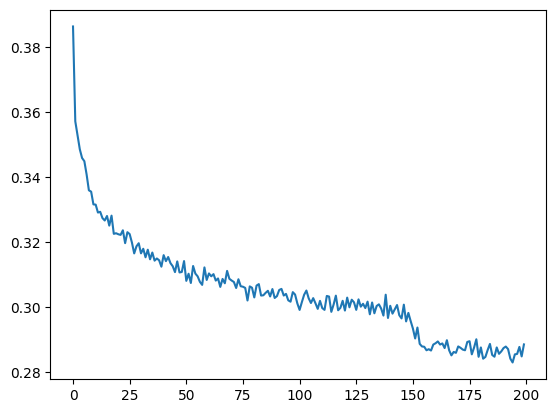

In [159]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [160]:
# Put layers into evaluation mode (needed esp. for batchnorm)
for layer in model.layers:
    layer.training = False

In [161]:
# Evaluate the loss
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side for this function)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]   # That's a switch!
    
    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9114720821380615
val 2.019570827484131


**Performance log:**

|                                              |train|val  |
| -------------------------------------------- | --- | --- |
| original (3 characters, 12K params)          |2.058|2.105|
| context: 3 $\rightarrow$ 8 (22K params)      |1.918|2.033|
| flat $\rightarrow$ hierarchical (22K params) |1.942|2.029|
| fix bug in batchnorm (22K params)            |1.911|2.019|

In [162]:
# Sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass though the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    # Decode and print the generated words (Inferences)
    print(''.join(itos[i] for i in out))

jaspinger.
kelly.
anna.
milonna.
bankin.
darielle.
denesse.
julian.
braya.
zieha.
ahmarice.
aniy.
aren.
ieroseb.
shalees.
aryabah.
jolana.
olenity.
nechlea.
thivae.


## Going Wider

We can now increase the network's hidden layer sizes, as the components are checked for bugs.

In [166]:
torch.manual_seed(42); # For reproducibility

In [167]:
n_embd = 24    # Dimensionality of the character embedding vectors
n_hidden = 128 # Number of neurons in the hidden layer of the MLP

# This sets up the actual network's design
model = Sequential([
    Embedding(vocab_size, n_embd),   # Previously C = torch.randn((vocab_size, n_embd))
    # The new layer at work now (block_size was 8 before)
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # Making last layer less confident

# before: [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [168]:
# Full Training
# Same optimization as last time (written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the current (new) gradients
    
    # Update (SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    #break # We see if this works first

      0/ 200000: 3.6596
  10000/ 200000: 2.0551
  20000/ 200000: 2.0342
  30000/ 200000: 2.6254
  40000/ 200000: 2.1558
  50000/ 200000: 1.7977
  60000/ 200000: 2.2949
  70000/ 200000: 1.8409
  80000/ 200000: 1.6752
  90000/ 200000: 2.1980
 100000/ 200000: 1.9085
 110000/ 200000: 2.0375
 120000/ 200000: 1.7248
 130000/ 200000: 1.8603
 140000/ 200000: 1.8157
 150000/ 200000: 1.9445
 160000/ 200000: 1.7933
 170000/ 200000: 1.6338
 180000/ 200000: 1.5115
 190000/ 200000: 1.8932


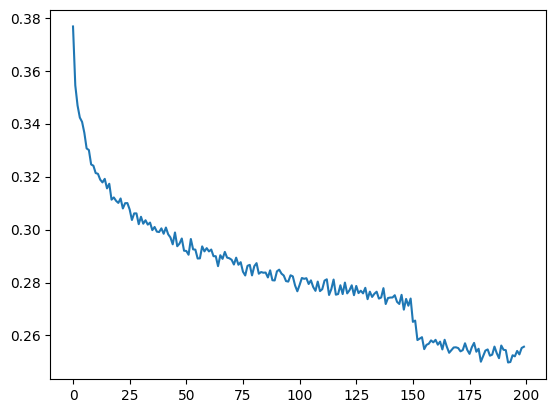

In [169]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [170]:
# Put layers into evaluation mode (needed esp. for batchnorm)
for layer in model.layers:
    layer.training = False

In [171]:
# Evaluate the loss
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side for this function)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]   # That's a switch!
    
    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7686810493469238
val 1.9930694103240967


**Performance log:**

|                                              |train|val  |
| -------------------------------------------- | --- | --- |
| original (3 characters, 12K params)          |2.058|2.105|
| context: 3 $\rightarrow$ 8 (22K params)      |1.918|2.033|
| flat $\rightarrow$ hierarchical (22K params) |1.942|2.029|
| fix bug in batchnorm (22K params)            |1.911|2.019|
| scale up the network (76K params)            |1.769|1.993|

In [172]:
# Sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass though the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    # Decode and print the generated words (Inferences)
    print(''.join(itos[i] for i in out))

apoljwah.
tayone.
jossadette.
helejwa.
jamyah.
abrsei.
loge.
brennet.
blayah.
aragras.
anny.
annayvi.
aurah.
jayce.
nodine.
remit.
dniya.
ganiyla.
demary.
anaya.


Normally, you would look deeply at both training loss and validation loss during model optimization.<br>
We didn't do that, just taking the graph with the training loss as some sort of guide was sufficient for our purposes.<br>
Technically, we now implemented the method laid out in the [WaveNet](https://arxiv.org/abs/1609.03499) paper.

You can name what we just did by its more familiar name: **Simple 1D convolutions.** 

![](https://media.tenor.com/Vr9P0tRw8QIAAAAM/look-holy.gif)

## Development Process of Deep Neural Networks

1. We spent a lot of time in the documentation page of [PyTorch](https://pytorch.org/docs/stable/nn.html) (actually, this documentation is not that good)
2. There's a lot of gymnastics around these multidimensional arrays we trickle through a model (3D, 2D, what input shapes, what output shapes, what hidden traps)
3. Prototyping shapes and layers in Jupyter notebooks, put VS Code and Jupyter Notebook on the side

### Rough Roadmap

We'll consider using the 'real' `torch.nn` to be an unlocked achievement from now on.<br>
We know what it's doing in complex enough terms. **RNNs and LSTMs will follow.**

### Challenge for now

Beat the $1.993$ validation loss of the last model through changing the model and/or its parameters.

In [175]:
n_embd = 26    # RAISED Dimensionality of the character embedding vectors
n_hidden = 128 # Number of neurons in the hidden layer of the MLP

# This sets up the actual network's design
model = Sequential([
    Embedding(vocab_size, n_embd),   # Previously C = torch.randn((vocab_size, n_embd))
    # The new layer at work now (block_size was 8 before)
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # Making last layer less confident

# before: [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
  p.requires_grad = True

77145


In [176]:
# Full Training
# Same optimization as last time (written a bit differently)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y's of this batch
    
    # Forward-Pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        # Making sure that prior iteration's gradients are gone
        p.grad = None
    loss.backward() # This calculates the current (new) gradients
    
    # Update (SGD with no fluff)
    lr = 0.1 if i < 150000 else 0.01 if i < 180000 else 0.001 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    #break # We see if this works first

      0/ 200000: 3.3710
  10000/ 200000: 2.2575
  20000/ 200000: 2.4482
  30000/ 200000: 1.9136
  40000/ 200000: 2.3482
  50000/ 200000: 1.9565
  60000/ 200000: 1.8290
  70000/ 200000: 1.7270
  80000/ 200000: 1.8911
  90000/ 200000: 1.6795
 100000/ 200000: 2.0539
 110000/ 200000: 2.2396
 120000/ 200000: 2.2207
 130000/ 200000: 1.3878
 140000/ 200000: 1.5571
 150000/ 200000: 1.8661
 160000/ 200000: 1.4331
 170000/ 200000: 2.0536
 180000/ 200000: 1.9294
 190000/ 200000: 1.8688


train 1.7690072059631348
val 1.984166145324707


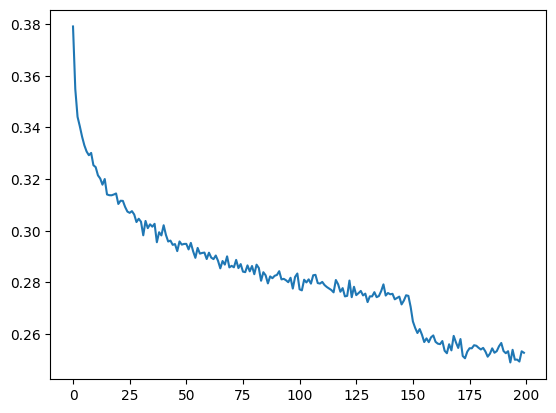

In [177]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

# Put layers into evaluation mode (needed esp. for batchnorm)
for layer in model.layers:
    layer.training = False

# Evaluate the loss
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side for this function)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]   # That's a switch!
    
    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>